## 🧬 Interactive Demo: Visual XAI for Malaria Diagnosis with SPCNN

This notebook walks you through a hands-on demonstration of how to generate and visualize explanations for a deep learning–based malaria classifier. We’ll use a **pretrained Soft-Attention Parallel CNN (SPCNN)**—architecture derived from Ahamed *et al.* (2025) [​Paper​](https://www.nature.com/articles/s41598-025-90851-1)—and illustrate four popular visual‐XAI techniques:

1. **Grad-CAM** – class‐activation heatmaps via gradients  
2. **Grad-CAM++** – improved localization of small regions  
3. **SHAP**  
   - *GradientSHAP* – approximate Shapley values using gradients  
   - *KernelExplainer* – model‐agnostic Shapley values  
4. **LIME** – local interpretable model‐agnostic explanations

> **Dataset**  
> NIH Malaria Dataset (27 k+ red blood cell images; infected vs. uninfected)  
> [Download & details](https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html)

### What you’ll see in this notebook

- **Model & data setup**  
  Load a small set of blood‐smear images and our trained SPCNN on CPU/GPU.  
- **Hooking explanation layers**  
  Dynamically attach hooks to the selected convolutional block (from YAML config) for Grad‐CAM and Grad‐CAM++.  
- **Generating heatmaps**  
  Apply each XAI method to the same input images and produce saliency or activation maps.  
- **Overlay & compare**  
  Overlay your heatmaps on the raw images and compare how each technique highlights different features.  
- **Reusable utilities**  
  Explore helper functions for batching, overlaying, and visualizing results in a consistent style.

This demo is a self‐contained template for exploring model interpretability in biomedical imaging—feel free to adapt it to your own datasets, models, or XAI methods!  

### ▶️ Load Sample Images & Pretrained SPCNN Model

In this step, we:

1. **Configure paths** to our sample blood-smear images and the saved SPCNN checkpoint.  
2. **Initialize the SPCNN** (Soft-Attention Parallel CNN) for binary classification (`infected` vs. `uninfected`) on the available device (CPU/GPU).  
3. **Load and remap the checkpoint** weights into the model, handling any legacy key names.  
4. **Build the preprocessing pipeline** (resize → CLAHE → dilation) so that each image is transformed into the exact tensor format expected by the network.  

After running this cell, you’ll have both the model and a list of sample images ready for explainability analyses.  

In [5]:
# hide_input
# ▶️ Run this cell to load sample images & SPCNN base model.
print("▶️ Loading sample images & SPCNN model…")

import sys, os
from pathlib import Path

# 1) Make sure repo root is on PYTHONPATH
repo_root = Path(os.getcwd()).parent
sys.path.insert(0, str(repo_root))

# 2) Config paths
DATA_PATH    = repo_root / "notebooks" / "sample_data"
WEIGHTS_PATH = repo_root / "notebooks" / "src" / "model.pth"

# 3) Model & device
import torch
from models.model_factory import get_model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cfg = {"name": "spcnn", "num_classes": 2}
model = get_model(model_cfg).to(DEVICE).eval()

# 4) Load & remap checkpoint
checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
state_dict = checkpoint.get("state_dict", checkpoint)
mapped = {
    (k.replace("features.", "feature_extractor.") if k.startswith("features.") else k): v
    for k, v in state_dict.items()
}
model.load_state_dict(mapped, strict=False)

# 5) Sample images & preprocessing pipeline
import numpy as np
from PIL import Image
from data.transforms import get_preprocessing_pipeline

IMAGE_SIZE = 224
preprocess = get_preprocessing_pipeline(
    resize=(IMAGE_SIZE, IMAGE_SIZE),
    apply_clahe=True,
    apply_dilation=True
)

img_paths = sorted(DATA_PATH.glob("*.png"))

def load_and_preprocess(p: Path):
    img = Image.open(p).convert("RGB")
    tensor = preprocess(img)         
    return tensor.unsqueeze(0).to(DEVICE)

print(f"✅ Loaded {len(img_paths)} sample images and SPCNN model on {DEVICE}")


▶️ Loading sample images & SPCNN model…
✅ Loaded 10 sample images and SPCNN model on cpu


## 🔍 Grad-CAM & Grad-CAM++

**Grad-CAM** (Gradient-weighted Class Activation Mapping) produces class‐specific heatmaps by:
1. Computing the gradient of the target class score with respect to the feature maps of a chosen convolutional layer.  
2. Averaging these gradients spatially to obtain per‐channel “importance” weights.  
3. Weighting and summing the feature maps, then applying ReLU to highlight the most relevant regions.

**Grad-CAM++** extends this by using higher-order derivatives to better localize small or multiple salient regions.

Below, we’ll hook both explainers to the same target layer defined in our config and get ready to generate activation maps for any input image.  


In [6]:
# hide_input
# ▶️ Run this cell to hook Grad-CAM to the same target layer as in your scripts.

import torch, yaml
from explainability.gradcam import GradCAM

# 1) Helper to resolve a “dotted” layer path into the actual module
def resolve_target_module(model, layer_str):
    parts  = layer_str.split(".")
    module = model
    for p in parts:
        module = module[int(p)] if p.isdigit() else getattr(module, p)
    return module

# 2) Load your XAI config to get the exact layer string
GRADCAM_YAML = repo_root / "configs" / "xai_gradcam.yaml"
cfg = yaml.safe_load(open(GRADCAM_YAML, "r"))
layer_str = cfg["xai"]["target_layer"]  # e.g. "feature_extractor.4", check your YAML

# 3) Resolve and instantiate GradCAM
target_module = resolve_target_module(model, layer_str)
explainer     = GradCAM(model, target_module, device=DEVICE)

print(f"✅ GradCAM hooked to layer: {layer_str}")


✅ GradCAM hooked to layer: feature_extractor.1.3.block.0


In [7]:
import numpy as np
import cv2

def overlay_cam(orig_rgb: np.ndarray,
                cam: np.ndarray,
                alpha: float = 0.4,
                colormap=cv2.COLORMAP_JET):
    H, W = orig_rgb.shape[:2]
    orig_bgr = cv2.cvtColor(orig_rgb, cv2.COLOR_RGB2BGR)

    p_low, p_high = np.percentile(cam, [5, 99])
    cam_clipped   = np.clip(cam, p_low, p_high)
    cam_norm      = (cam_clipped - cam_clipped.min()) / (p_high - cam_clipped.min() + 1e-8)

    heat_u8  = (cam_norm * 255).astype(np.uint8)
    heat_bgr = cv2.applyColorMap(heat_u8, colormap)
    heat_bgr = cv2.resize(heat_bgr, (W, H), interpolation=cv2.INTER_LINEAR)

    blended = cv2.addWeighted(orig_bgr, 1 - alpha, heat_bgr, alpha, 0)
    mask    = np.any(orig_bgr != 0, axis=2)[:, :, None]
    result  = np.where(mask, blended, orig_bgr)

    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)


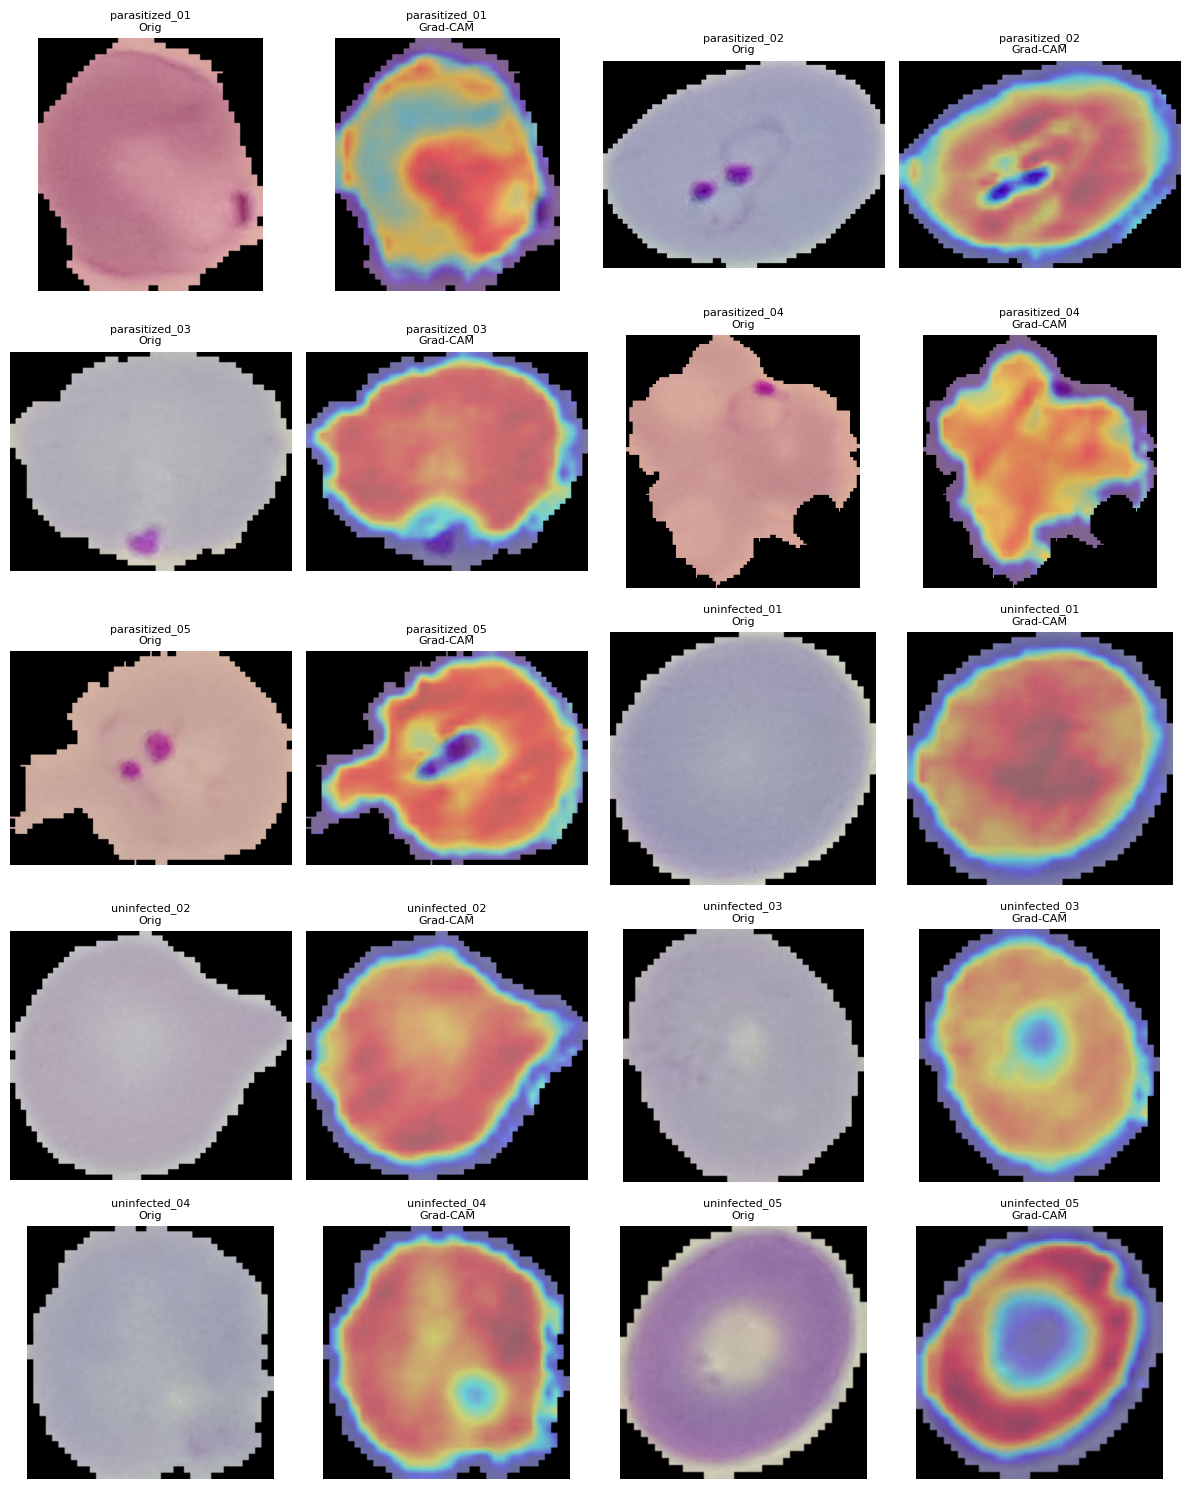

In [8]:
# hiden_input
# ▶️ Run this cell to create a function to xx

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from pathlib import Path

# Prepare grid
n_rows, n_cols = 5, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)

# blank all axes
for row in axes:
    for ax in row:
        ax.axis('off')

# Fill each row: orig & Grad-CAM for two samples per row
for idx, p in enumerate(img_paths):
    row = idx // 2
    pair_idx = idx % 2
    c_orig = pair_idx * 2
    c_cam  = c_orig + 1

    # preprocess & predict
    x    = load_and_preprocess(p)
    pred = model(x).argmax(dim=1).item()

    # generate & resize CAM
    cam = explainer.generate_heatmap(x, class_idx=pred)          # H×W numpy
    orig_arr = np.array(Image.open(p).convert("RGB"))
    h, w = orig_arr.shape[:2]
    cam_r = cv2.resize(cam, (w, h), interpolation=cv2.INTER_LINEAR)

    # plot original
    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title(f"{p.stem}\nOrig", fontsize=8)
    axes[row, c_orig].axis('off')

    # plot overlay
    ov = overlay_cam(orig_arr, cam, alpha=0.4)
    axes[row, c_cam].imshow(ov)
    axes[row, c_cam].set_title(f"{p.stem}\nGrad-CAM", fontsize=8)
    axes[row, c_cam].axis('off')

plt.tight_layout()
plt.show()


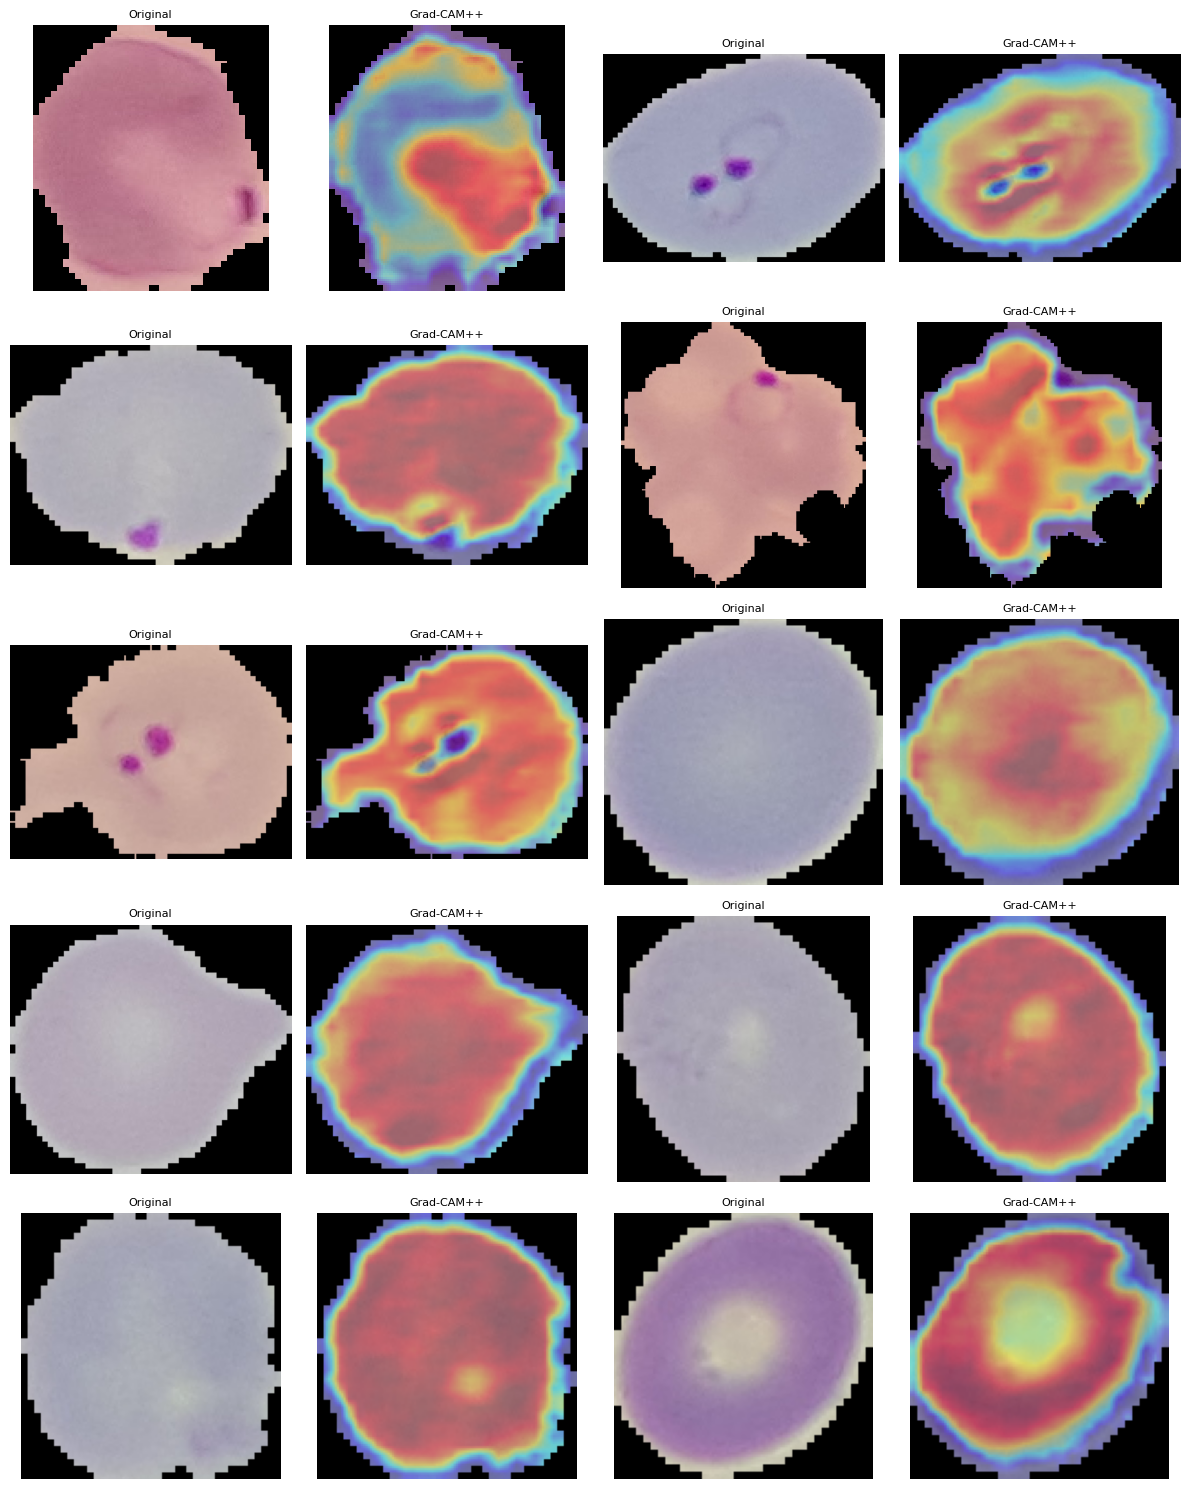

In [9]:
# ▶️ Run this cell to display Grad-CAM++ overlays in a 5×4 grid

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from explainability.gradcam_plus_plus import GradCAMPlusPlus

# instantiate Grad-CAM++
explainer_pp = GradCAMPlusPlus(model, target_module)

# prepare the grid
n_rows, n_cols = 5, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)
for row in axes:
    for ax in row:
        ax.axis('off')

# loop over sample images
for idx, p in enumerate(img_paths):
    row      = idx // 2
    pair_idx = idx % 2
    c_orig   = pair_idx * 2
    c_cam    = c_orig + 1

    # load & predict
    x    = load_and_preprocess(p)
    pred = model(x).argmax(dim=1).item()

    # generate CAM and resize it
    cam_tensor = explainer_pp(x, class_idx=pred)
    cam        = cam_tensor[0].detach().cpu().numpy()
    orig_arr   = np.array(Image.open(p).convert("RGB"))
    h, w       = orig_arr.shape[:2]
    cam_r      = cv2.resize(cam, (w, h), interpolation=cv2.INTER_LINEAR)

    # plot original
    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title("Original", fontsize=8)

    # plot overlay
    ov = overlay_cam(orig_arr, cam, alpha=0.4)
    axes[row, c_cam].imshow(ov)
    axes[row, c_cam].set_title("Grad-CAM++", fontsize=8)

plt.tight_layout()
plt.show()


## 🌟 SHAP Explanations

SHAP (SHapley Additive exPlanations) assigns each input feature (pixel) an importance value by estimating how much it contributes to the model’s output. We’ll demonstrate two variants:

1. **GradientSHAP**  
   - A fast, gradient‐based approximation that blends integrated gradients with random baselines.  
   - Good for quick saliency maps that approximate Shapley values.

2. **KernelExplainer**  
   - A model‐agnostic, sampling‐based explainer that uses the Shapley kernel to compute exact Shapley values over superpixel regions or flattened inputs.  
   - More accurate but slower, useful for spot‐checking individual examples.

Below, we’ll hook up both explainers so you can compare their attributions side‐by‐side.  


In [10]:
# hide_input
# ▶️ Run this cell to set up SHAP Deep & Gradient Explainers on four samples
import warnings
warnings.filterwarnings("ignore", message="unrecognized nn.Module")
from explainability.shap import SHAPExplainer
from scipy.ndimage import gaussian_filter

# pick two parasitized and two uninfected samples
pos_paths = [p for p in img_paths if "parasitized" in p.stem][:2]
neg_paths = [p for p in img_paths if "uninfected" in p.stem][:2]
# background built from these same four
tensors = [load_and_preprocess(p) for p in pos_paths + neg_paths]
background = torch.cat(tensors, dim=0)

# instantiate Deep and Gradient explainers
explainer_deep = SHAPExplainer(
    model,
    background,
    device=DEVICE,
    explainer_type="deep",
    nsamples=0
)
explainer_grad = SHAPExplainer(
    model,
    background,
    device=DEVICE,
    explainer_type="gradient",
    nsamples=50
)
print("✅ SHAP explainers (Deep & Gradient) ready for four images")

✅ SHAP explainers (Deep & Gradient) ready for four images


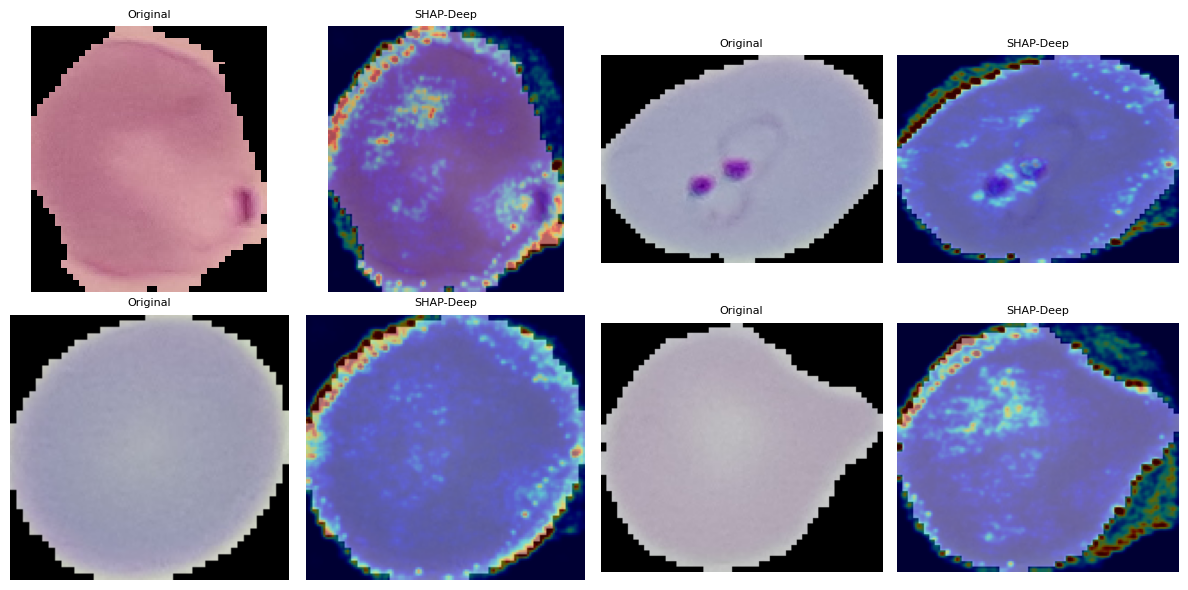

In [11]:
# ▶️ Run this cell to display SHAP-Deep overlays for four images
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

# grid: 2 rows, each with orig + SHAP pairs
test_paths = pos_paths + neg_paths
n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)
for row in axes:
    for ax in row:
        ax.axis('off')

for idx, p in enumerate(test_paths):
    row = idx // 2
    pair_idx = idx % 2
    c_orig = pair_idx * 2
    c_shap = c_orig + 1

    # load
    orig_arr = np.array(Image.open(p).convert("RGB"))
    x = load_and_preprocess(p)
    pred = model(x).argmax(dim=1).item()

    # compute SHAP map
    shap_map = explainer_deep(x, class_idx=pred)
    # ensure channel-last attribution: shap_map shape is (1, H, W, C)
    shap_arr = shap_map[0].detach().cpu().numpy()
    # extract attribution for predicted class channel
    cam_raw = np.abs(shap_arr[:, :, pred])
    cam_smooth = gaussian_filter(cam_raw, sigma=1.5)

    # normalize like save_cam
    p_low, p_high = np.percentile(cam_smooth, [5, 99])
    cam_clipped = np.clip(cam_smooth, p_low, p_high)
    cam_norm = (cam_clipped - p_low) / (p_high - p_low + 1e-8)

    h, w = orig_arr.shape[:2]
    heat_bgr = cv2.applyColorMap((cam_norm*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat_bgr = cv2.resize(heat_bgr, (w, h), interpolation=cv2.INTER_LINEAR)
    orig_bgr = cv2.cvtColor(orig_arr, cv2.COLOR_RGB2BGR)
    over_bgr = cv2.addWeighted(orig_bgr, 0.6, heat_bgr, 0.4, 0)
    ov = cv2.cvtColor(over_bgr, cv2.COLOR_BGR2RGB)

    # plot
    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title("Original", fontsize=8)
    axes[row, c_shap].imshow(ov)
    axes[row, c_shap].set_title("SHAP-Deep", fontsize=8)

plt.tight_layout()
plt.show()

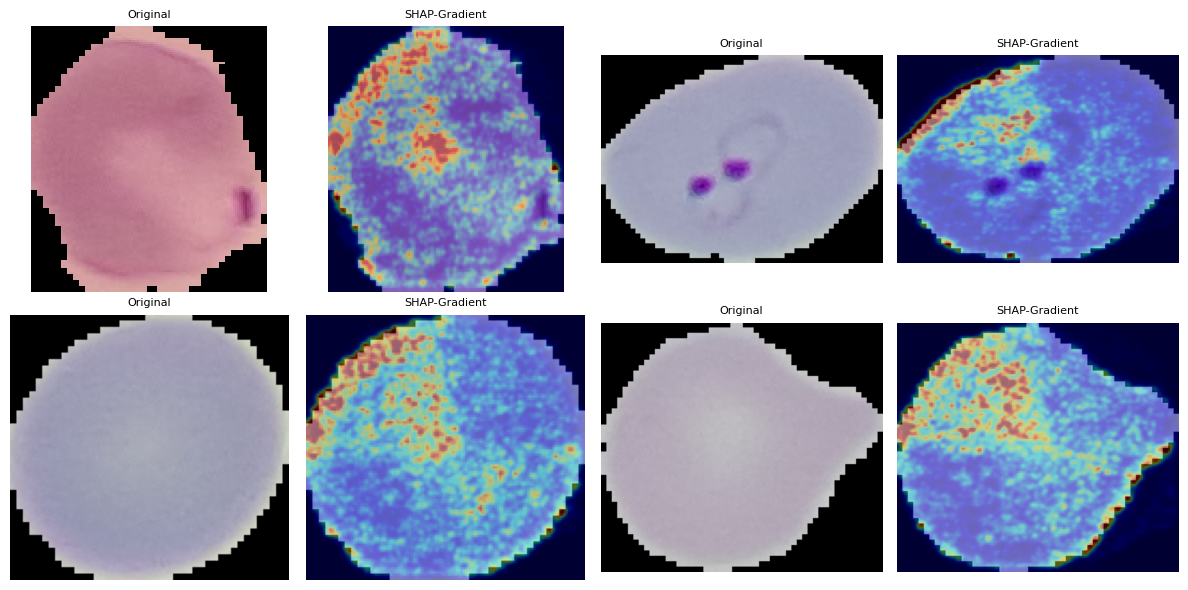

In [12]:
# ▶️ Run this cell to display SHAP-Gradient overlays for four images
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)
for row in axes:
    for ax in row: ax.axis('off')

for idx, p in enumerate(test_paths):
    row = idx // 2
    pair_idx = idx % 2
    c_orig, c_shap = pair_idx*2, pair_idx*2+1

    orig_arr = np.array(Image.open(p).convert("RGB"))
    x = load_and_preprocess(p)
    pred = model(x).argmax(dim=1).item()

    shap_map = explainer_grad(x, class_idx=pred)
    shap_arr = shap_map[0].detach().cpu().numpy()
    cam_raw = np.abs(shap_arr[:, :, pred])
    cam_smooth = gaussian_filter(cam_raw, sigma=1.5)

    p_low, p_high = np.percentile(cam_smooth, [5, 99])
    cam_clipped = np.clip(cam_smooth, p_low, p_high)
    cam_norm = (cam_clipped - p_low) / (p_high - p_low + 1e-8)

    H, W = orig_arr.shape[:2]
    heat_bgr = cv2.applyColorMap((cam_norm*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat_bgr = cv2.resize(heat_bgr, (W, H), interpolation=cv2.INTER_LINEAR)
    orig_bgr = cv2.cvtColor(orig_arr, cv2.COLOR_RGB2BGR)
    over_bgr = cv2.addWeighted(orig_bgr, 0.6, heat_bgr, 0.4, 0)
    ov = cv2.cvtColor(over_bgr, cv2.COLOR_BGR2RGB)

    axes[row, c_orig].imshow(orig_arr)
    axes[row, c_orig].set_title("Original", fontsize=8)
    axes[row, c_shap].imshow(ov)
    axes[row, c_shap].set_title("SHAP-Gradient", fontsize=8)

plt.tight_layout()
plt.show()

##  LIME Explanations

LIME (Local Interpretable Model‐agnostic Explanations) explains individual predictions by learning a simple surrogate model in the vicinity of the target example:

1. **Superpixel segmentation**  
   Partition the image into contiguous “superpixels” (regions of similar color/texture).  
2. **Perturbation sampling**  
   Create many quasirandom samples by turning off (masking) subsets of superpixels.  
3. **Model queries**  
   Run the original SPCNN on each perturbed image to collect predicted probabilities.  
4. **Weighted linear fit**  
   Fit a sparse linear model that weights each perturbed sample by its similarity to the original (unmasked) image.  
5. **Feature importance**  
   The linear model’s coefficients indicate which superpixels most positively or negatively influence the prediction.

Below, we’ll instantiate a `LimeImageExplainer`, generate local explanations for our malaria classifier, and visualize the top contributing regions for each class.  


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

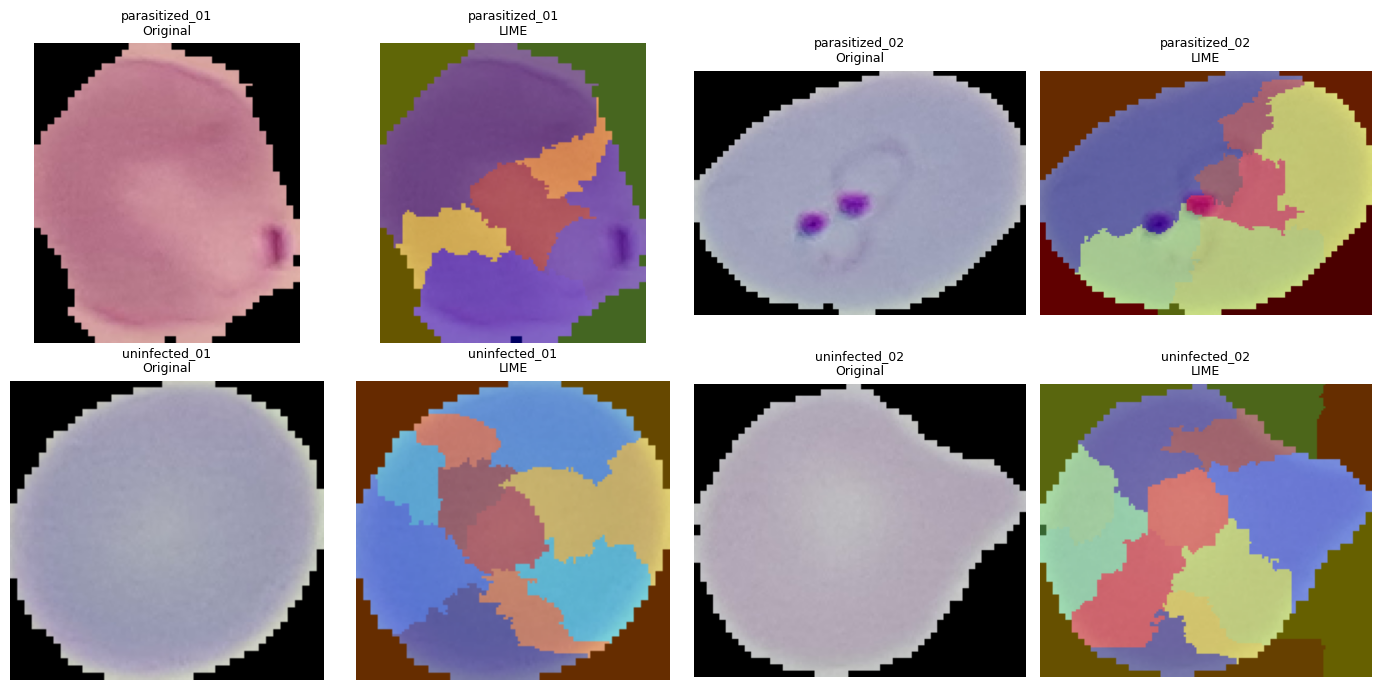

In [13]:
# ▶️ Run this cell to display LIME explanations like SHAP (no saving, no patching)

from lime import lime_image
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import cv2

# 1) LIME-compatible prediction function (input = list of np arrays, output = probs)
def predict_fn(images_np):
    batch = torch.stack([
        preprocess(Image.fromarray(img).convert("RGB"))
        for img in images_np
    ]).to(DEVICE)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

# 2) Initialize LIME
lime_explainer = lime_image.LimeImageExplainer()

# 3) Select 2 infected + 2 uninfected images
infected   = [p for p in img_paths if "parasitized" in p.name][:2]
uninfected = [p for p in img_paths if "uninfected" in p.name][:2]
selected   = infected + uninfected

# 4) Helper: Convert CAM + original RGB to overlay image
def get_overlay_from_lime(explanation, class_idx, orig_rgb):
    segments = explanation.segments
    weights  = dict(explanation.local_exp[class_idx])

    cam = np.zeros_like(segments, dtype=float)
    for seg_id, weight in weights.items():
        cam[segments == seg_id] = weight

    cam_norm = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    heat_u8  = np.uint8(cam_norm * 255)
    heatmap  = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)
    overlay  = cv2.addWeighted(cv2.cvtColor(orig_rgb, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    return cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# 5) Plot: 2×4 grid (Original | LIME)
fig, axes = plt.subplots(2, 4, figsize=(14, 7), squeeze=False)

for idx, img_path in enumerate(selected):
    row = idx // 2
    col = (idx % 2) * 2

    orig = Image.open(img_path).convert("RGB")
    arr  = np.array(orig)

    # Get prediction label
    x = preprocess(orig).unsqueeze(0).to(DEVICE)
    pred = model(x).argmax(dim=1).item()

    # Run LIME
    explanation = lime_explainer.explain_instance(
        image=arr,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=200
    )

    # Overlay
    overlay = get_overlay_from_lime(explanation, class_idx=pred, orig_rgb=arr)

    axes[row, col].imshow(arr)
    axes[row, col].set_title(f"{img_path.stem}\nOriginal", fontsize=9)
    axes[row, col].axis("off")

    axes[row, col + 1].imshow(overlay)
    axes[row, col + 1].set_title(f"{img_path.stem}\nLIME", fontsize=9)
    axes[row, col + 1].axis("off")

plt.tight_layout()
plt.show()
